In [9]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn
from ot import emd2  # Wasserstein distance computation
from tqdm import tqdm

%matplotlib widget

# check available device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset
Gaussian Mixture Model

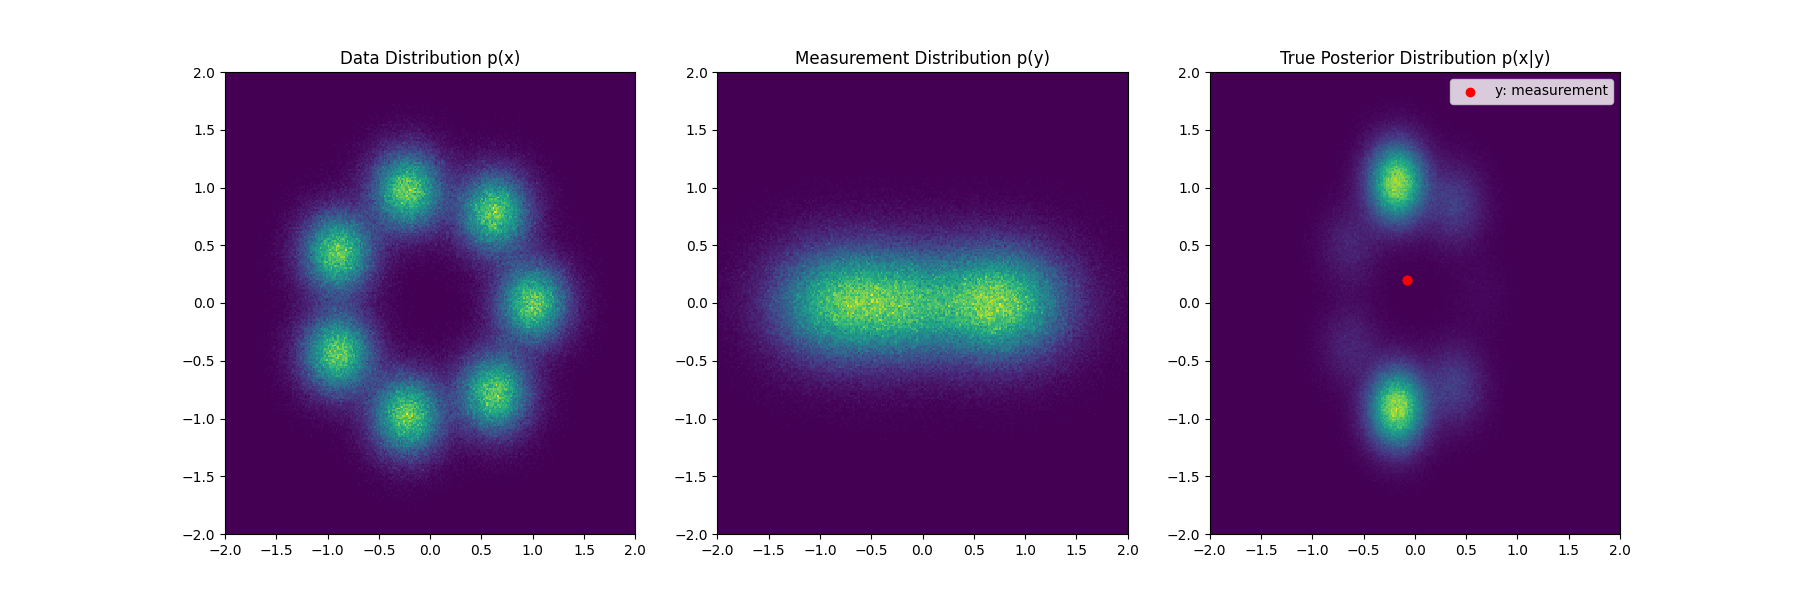

In [10]:
from scipy.stats import multivariate_normal
from sklearn.datasets import make_moons


class DataDistribution:
    def __init__(self, config):
        self.mu = []
        self.sig = []
        self.L_sig = []
        self.generator = np.random.RandomState(0)
        # get mus from config
        for i in range(len(config['gaussians'])):
            self.mu.append(np.array(config['gaussians'][i]['mu']))
            self.sig.append(np.array(config['gaussians'][i]['cov']))
            self.L_sig.append(np.linalg.cholesky(self.sig[i]))
        self.mu = np.array(self.mu)
        self.sig = np.array(self.sig)
        self.L_sig = np.array(self.L_sig)

    def __call__(self, n_samples=1):
        # sample which gaussian to sample from use random state
        idx = np.random.choice(len(self.mu), n_samples)
        # sample from the chosen gaussian
        
        return self.mu[idx][...,0] + np.einsum("nij, nj->ni", self.L_sig[idx], np.random.randn(n_samples, 2)) #self.L_sig[idx]@np.random.randn(2, n_samples).T)
    
    def sample(self, n_samples=1):
        return self(n_samples)

config = {
'gaussians': [
    {'mu': [[3],[-6]], 'cov': [[1,0.25],[0.25,1]]},
    {'mu': [[-2],[3]], 'cov': [[2,-1.5],[-1.5,2]]},
    {'mu': [[3],[6]], 'cov': [[0.2,-0.1],[-0.1,2]]}
]}

data_dist = DataDistribution(config)

# config for 8 gaussians in a circle
r  = 1
sigma = 5e-2
n_gaussians = 7
config_circle = {
'gaussians': [
    {'mu': [[r*np.cos(2*np.pi*i/n_gaussians)],[r*np.sin(2*np.pi*i/n_gaussians)]], 'cov': [[sigma,0],[0,sigma]]} for i in range(n_gaussians)
]}

gaussian_circle = DataDistribution(config_circle)

# define forward process and degrade data with forward process and noise
class BasicForwardModel:
    def __init__(self, data_distribution, config):
        self.data_dist = data_distribution
        # identity matrix
        self.A = np.array([[1,0],[0,1]])
        # noise level
        self.mu = np.array(config['mu'])
        self.sig = np.diag(np.array(config['cov']))
        self.L_sig = np.linalg.cholesky(self.sig)
    
    def __call__(self, n_samples=1):
        # forward process
        x = self.data_dist(n_samples)
        # forward operator
        y = x@self.A.T
        # add noise
        
        y += (self.L_sig@np.random.randn(2, n_samples)).T + self.mu[None]
        return y
    
    def get_p_y(self, y):
        p_y = []
        for j in range(self.data_dist.mu.shape[0]):
            mu = self.A@self.data_dist.mu[j] + self.mu[:,None]
            sig = self.A@self.data_dist.sig[j]@self.A.T + self.sig
            p_y.append(multivariate_normal.pdf(y, mean=mu[:,0],cov=sig))
        return p_y
    
    def unnormalized_posterior(self, y):
        self.post_mu = []
        self.post_sig = []
        self.post_cholesky = []
        for i in range(self.data_dist.mu.shape[0]):
            mu_data = self.data_dist.mu[i][None]
            sig_data = self.data_dist.sig[i][None]
            mu_post = mu_data + (sig_data @ np.linalg.inv(sig_data + self.sig)) @ (y[...,None] - self.A[None]@mu_data)
            self.post_mu.append(mu_post[0])
            sig_post = sig_data - self.A[None]@sig_data @ np.linalg.inv(sig_data + self.sig) @ self.A[None]@sig_data
            self.post_sig.append(sig_post[0])
            self.post_cholesky.append(np.linalg.cholesky(sig_post[0]))
        self.post_mu = np.array(self.post_mu)
        self.post_sig = np.array(self.post_sig)
        self.post_cholesky = np.array(self.post_cholesky)
    
    def sample_posterior(self, y, n_samples=1):
        self.unnormalized_posterior(y)
        p_y = self.get_p_y(y)
        # sample idx of gaussian with probability p_y
        idx = np.random.choice(self.post_mu.shape[0], n_samples, p=p_y/np.sum(p_y))
        return self.post_mu[idx][...,0] + np.einsum("nij, nj->ni", self.post_cholesky[idx], np.random.randn(n_samples, 2))

    def set_A(self, A):
        self.A = A


class MoonDataset:
    def __init__(noise=0.05):
        self.noise = noise

    def __call__(self, n_samples=1):
        x = make_moons(n_samples, noise=self.noise)[0]
        x = torch.tensor(x).type(torch.float32)
        return x
    
    def sample(self, n_samples=1):
        return self(n_samples)
    
measurement_model = BasicForwardModel(gaussian_circle, {'mu': [0,0], 'cov': [0.1,0.1]})
# projection on x-axis
measurement_model.set_A(np.array([[1,0],[0,0]]))
# plot posterior samples
# 1. sample measurement
n_samples = 1000000
y = measurement_model(1)
y_samples = measurement_model(n_samples)
x_samples = gaussian_circle(n_samples)
post_samples = measurement_model.sample_posterior(y, n_samples)
# plot measurement_model.post_mu
# aspect ratio 1:1
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
# plot
axs[0].set_title('Data Distribution p(x)')
axs[0].hist2d(x_samples[:,0],x_samples[:,1],bins=256, range=[[-2, 2], [-2, 2]])
axs[1].set_title('Measurement Distribution p(y)')
axs[1].hist2d(y_samples[:,0],y_samples[:,1],bins=256, range=[[-2, 2], [-2, 2]])
axs[2].set_title('True Posterior Distribution p(x|y)')
axs[2].hist2d(post_samples[:,0],post_samples[:,1],bins=256, range=[[-2, 2], [-2, 2]])
axs[2].scatter(y[:,0],y[:,1],c='r',label='y: measurement')
axs[2].legend()
# label with 'true posterior'


plt.scatter(y[0,0],y[0,1],c='r')
plt.show()


## DDIM Test Time Guidance


In [11]:
y_measurements = torch.Tensor(measurement_model(100)).to(device)
y = y_measurements[:1]

In [12]:
class GaussianMixtureModel(torch.nn.Module):
    """
    A class for Gaussian Mixture Models (GMM) with methods to compute the probability density
    and the gradient of the log-density.
    """
    def __init__(self, n_gaussians, dim):
        """
        Initialize the GMM with weights, means, and covariances.
        Args:
            n_gaussians (int): The number of Gaussians in the mixture.
            dim (int): The dimensionality of the data.
        """
        super(GaussianMixtureModel, self).__init__()
        self.weights = torch.rand(n_gaussians)
        # nomralize weights
        self.weights = self.weights / torch.sum(self.weights)
        self.weights = nn.Parameter(self.weights)
        self.means = nn.Parameter(torch.randn(n_gaussians, dim))
        self.dim = dim  # Dimensionality of the data
        # Number of parameters needed for a lower triangular matrix
        self.num_params = self.dim * (self.dim + 1) // 2
        # Trainable parameters for the lower triangular matrix (actually log(L))
        self.L = nn.Parameter(torch.randn(n_gaussians, self.num_params))
        self.K = n_gaussians  # Number of components
        self.relu = nn.ReLU()

    @classmethod
    def from_existing(cls, weights, means, covariance):
        """
        Initialize the GMM with existing weights, means, and covariance matrices.
        Args:
            weights List: The weights of the Gaussians List with k entries.
            means List(torch.Tensor): The means of the Gaussians list with K entries of d dimensional tensor.
            covariance List(torch.Tensor): The covariance matrices of the Gaussians list with K entries of dxd dimensional tensor.
        """
        n_gaussians = len(weights)
        dim = means[0].shape[0]
        gmm = cls(n_gaussians, dim)
        weights = torch.tensor(weights)
        means = torch.stack(means)
        covariance = torch.stack(covariance)
        gmm.weights = nn.Parameter(weights)
        gmm.means = nn.Parameter(means)
        L = torch.linalg.cholesky(covariance)
        # get lower triangular indices
        diag_idx = torch.arange(dim)
        L[:, diag_idx, diag_idx] = torch.log(L[:, diag_idx, diag_idx]+1e-7)
        L_idx = torch.tril_indices(dim, dim)
        L = L[:, L_idx[0], L_idx[1]]
        # log of diagonal
        gmm.L = nn.Parameter(L.reshape(n_gaussians, -1))
        return gmm
    
    def scale(self, scale):
        """
        Returns a new GMM which models the data scaled by the given scale factor.
        """
        scaled_gmm = GaussianMixtureModel(self.K, self.dim)
        scaled_gmm.weights.data = self.weights
        scaled_gmm.means.data = self.means * scale
        scaled_gmm.L.data = self.L
        covariances = scaled_gmm.get_covariances()
        covariances = covariances * scale**2
        L = torch.linalg.cholesky(covariances)
        # log of diagonal
        diag_idx = torch.arange(self.dim)
        L[:, diag_idx, diag_idx] = torch.log(L[:, diag_idx, diag_idx]+1e-7)
        L_idx = torch.tril_indices(self.dim, self.dim)
        L = L[:, L_idx[0], L_idx[1]]
        scaled_gmm.L.data = L.reshape(self.K, -1)

        
        return scaled_gmm
    
    def add_noise(self, noise_cov):
        """
        Returns a new GMM which models the data with added noise.
        """
        noised_gmm = GaussianMixtureModel(self.K, self.dim)
        noised_gmm.weights = self.weights
        noised_gmm.means.data = self.means
        noised_gmm.L.data = self.L
        covariances = noised_gmm.get_covariances()
        covariances = covariances + noise_cov[None]
        L = torch.linalg.cholesky(covariances)
        diag_idx = torch.arange(self.dim)
        L[:, diag_idx, diag_idx] = torch.log(L[:, diag_idx, diag_idx]+1e-7)
        L_idx = torch.tril_indices(self.dim, self.dim)
        L = L[:, L_idx[0], L_idx[1]]
        noised_gmm.L.data = L.reshape(self.K, -1)
        return noised_gmm


    def get_covariances(self):
        """
        Compute the covariance matrices from the lower triangular matrix.
        Returns:
            torch.Tensor: Covariance matrices (K x d x d tensor).
        """
        L = torch.zeros(self.K, self.dim, self.dim)
        L_idx = torch.tril_indices(self.dim, self.dim)
        L[:, L_idx[0], L_idx[1]] = self.L
        # Ensure diagonal elements are positive
        diag_idx = torch.arange(self.dim)
        L[:, diag_idx, diag_idx] = torch.exp(L[:, diag_idx, diag_idx])  # Exponentiate diagonal for positivity
        covariances = L @ L.permute(0, 2, 1)  # Multiply by its transpose to get the covariance matrix
        return covariances

    def multivariate_gaussian(self, x, mean, cov):
        """
        Compute the probability density of a multivariate Gaussian.
        Args:
            x (torch.Tensor): The data point (d-dimensional vector) with batch dimension.
            mean (torch.Tensor): The mean of the Gaussian (d-dimensional vector).
            cov (torch.Tensor): The covariance matrix of the Gaussian (d x d matrix).
        Returns:
            torch.Tensor: The probability density of the Gaussian at x.
        """
        log_prob = torch.distributions.MultivariateNormal(mean, cov).log_prob(x)
        return torch.exp(log_prob)

    def pdf(self, x):
        """
        Compute the probability density of the GMM at a given point.
        Args:
            x (torch.Tensor): The data point (d-dimensional vector) with batch dimension.
        Returns:
            float: The probability density of the GMM at x.
        """
        covariances = self.get_covariances()
        return torch.sum(torch.stack([
            self.relu(self.weights[k]) * self.multivariate_gaussian(x, self.means[k], covariances[k])
            for k in range(self.K)
        ]), dim=0)

    def log_pdf_gradient(self, x):
        """
        Compute the gradient of the log of the GMM w.r.t. x.
        Args:
            x (torch.Tensor): The data point (d-dimensional vector) with batch dimension.
            cov_noise (torch.Tensor): vector of noise covariances with shape batch
        Returns:
            torch.Tensor: The gradient of the log of the GMM w.r.t. x (d-dimensional vector) with batch dimension.
        """
        # Compute the responsibilities
        covariances = self.get_covariances()
        # covariance of the noise
        densities = torch.stack([
            self.relu(self.weights[k]) * self.multivariate_gaussian(x, self.means[k][None], covariances[k][None])
            for k in range(self.K)
        ], dim=0)
        total_density = torch.sum(densities, dim=0)
        responsibilities = densities / total_density
        # Compute the gradient
        gradient = torch.zeros_like(x)
        for k in range(self.K):
            cov_inv = torch.inverse(covariances[k])
            diff = x - self.means[k][None]
            gradient -= responsibilities[k][...,None] * (cov_inv @ diff.T).T
        return gradient
    
    def sample(self, n_samples):
        """
        Sample from the GMM.
        Args:
            n_samples (int): The number of samples to generate.
        Returns:
            torch.Tensor: The generated samples.
        """
        covariances = self.get_covariances()
        # Sample index
        k = torch.multinomial(self.relu(self.weights), n_samples, replacement=True)
        # Sample from the corresponding Gaussian
        samples = self.means[k] + torch.einsum('bij, bj -> bi', torch.cholesky(covariances[k]), torch.randn(n_samples, self.dim))
        return samples
    
    def forward(self, x):
        """
        evaluate gt score

        """
        x, t = torch.split(x, [self.dim, 1], dim=1)
        

        

Define GMM (same as data model)

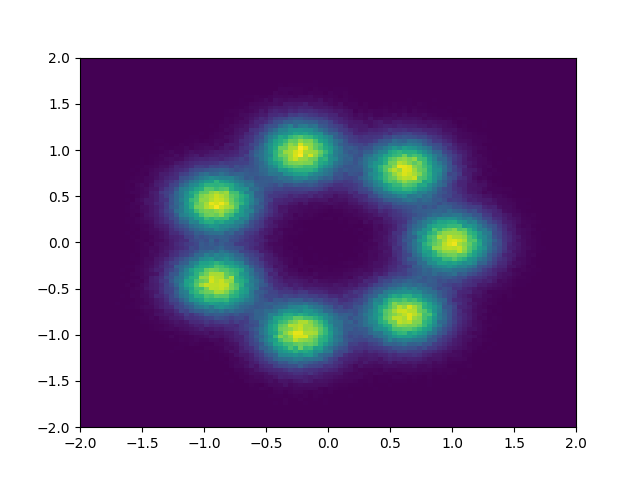

In [17]:
# use the grad of the log of the GMM as the denoiser and simulate the prior
means = [torch.Tensor([r*np.cos(2*np.pi*i/n_gaussians), r*np.sin(2*np.pi*i/n_gaussians)]) for i in range(n_gaussians)]
gmm = GaussianMixtureModel.from_existing([1/n_gaussians]*n_gaussians, means, [torch.eye(2)*sigma]*n_gaussians)
# add noise
a_t = 1
scaled_gmm = gmm.scale(a_t)
noise_cov = torch.eye(2) * (1-a_t)
noised_gmm = scaled_gmm.add_noise(noise_cov)
samples = noised_gmm.sample(1000000).detach().cpu().numpy()
plt.figure()
plt.hist2d(samples[:,0], samples[:,1], bins=100, range=[[-2, 2], [-2, 2]])
plt.show()

(100000,)


Text(0.5, 1.0, 'Density sampled with DDIM eta=0')

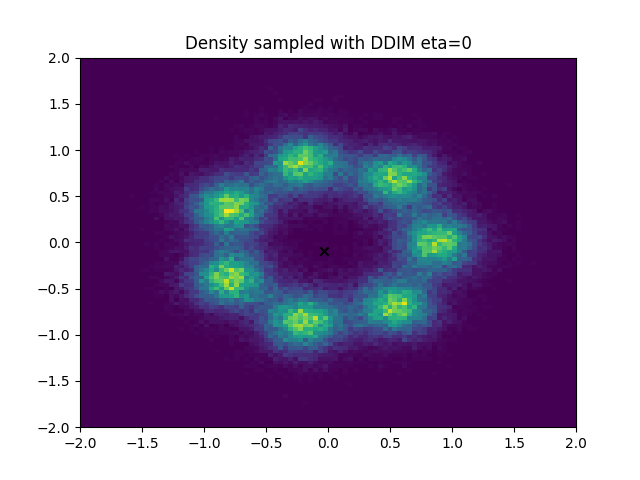

In [22]:
def guided_ddim_sampler_gt_score(gmm, y, ddim_config, x_t, likelihood_weight = 0.005, save_traj=False):
    if x_t is None:
        x_t = torch.randn(1,2).to(device)
    n_ddim_steps = ddim_config['n_ddim_steps']
    n_steps = ddim_config['n_steps']
    eta = ddim_config['eta']
    skip = int(n_steps/n_ddim_steps)
    timesteps = np.arange(n_steps,1,-skip).astype(int) - 1
    betas = torch.linspace(ddim_config['beta_min'],ddim_config['beta_max'],n_steps).to(device)
    alpha = 1 - betas
    alpha_cumprod = torch.cumprod(alpha, 0)
    if save_traj:
        traj = [x_t.detach().cpu().numpy()]
    for t, t_next in zip(timesteps, np.concatenate([timesteps[1:], [0]])):
        with torch.no_grad():
            a_t = alpha_cumprod[t]
            a_t_next = alpha_cumprod[t_next]
            scaled_gmm = gmm.scale(a_t)
            noise_cov = torch.eye(2) * (1-a_t)
            noised_gmm = scaled_gmm.add_noise(noise_cov)
            score = noised_gmm.log_pdf_gradient(x_t)
            eps_pred = -score * (1-a_t)**0.5
            # ddim step
            x0_t = (x_t - eps_pred * (1-a_t)**0.5) / a_t**0.5
            c1 = eta * ((1-a_t/a_t_next)* (1-a_t_next)/(1-a_t))**0.5
            c2 = ((1-a_t_next) - c1 **2)**0.5
            x_t = a_t_next**0.5 *x0_t + c1 * torch.randn_like(x_t) + c2 * eps_pred
            with torch.enable_grad():
                x_t.requires_grad_()
                y_generated = (torch.Tensor(measurement_model.A).to(device) @ x_t.T).T
                loss = torch.sum((y_generated - y)**2)
                loss.backward()
                gradients = x_t.grad
            # data term
            x_t = x_t - likelihood_weight * gradients
            if save_traj:
                traj.append(x_t.detach().cpu().numpy())
    return traj if save_traj else [x_t.detach().cpu().numpy()]

ddim_config = {'n_ddim_steps': 100, 'n_steps': 1000, 'beta_min': 1e-4, 'beta_max': 0.02, 'eta': 0}
x_t = torch.randn(100000,2).to(device)
traj = guided_ddim_sampler_gt_score(gmm, y, ddim_config, x_t, save_traj=False, likelihood_weight=0.00)
# plot density p(x)
plt.figure()
plt.title('Density sampled with GT score')
# plot trajectory
traj = np.array(traj)
print(traj[-1,:,0].shape)
plt.hist2d(traj[-1,:,0],traj[-1,:,1], bins=100, range=[[-2, 2], [-2, 2]])
# plot meaasurement y
plt.scatter(y[0,0].detach().cpu().numpy(),y[0,1].detach().cpu().numpy(), color='black', marker='x')
# add legend
# name
plt.title(f'Density sampled with DDIM eta={ddim_config["eta"]}')

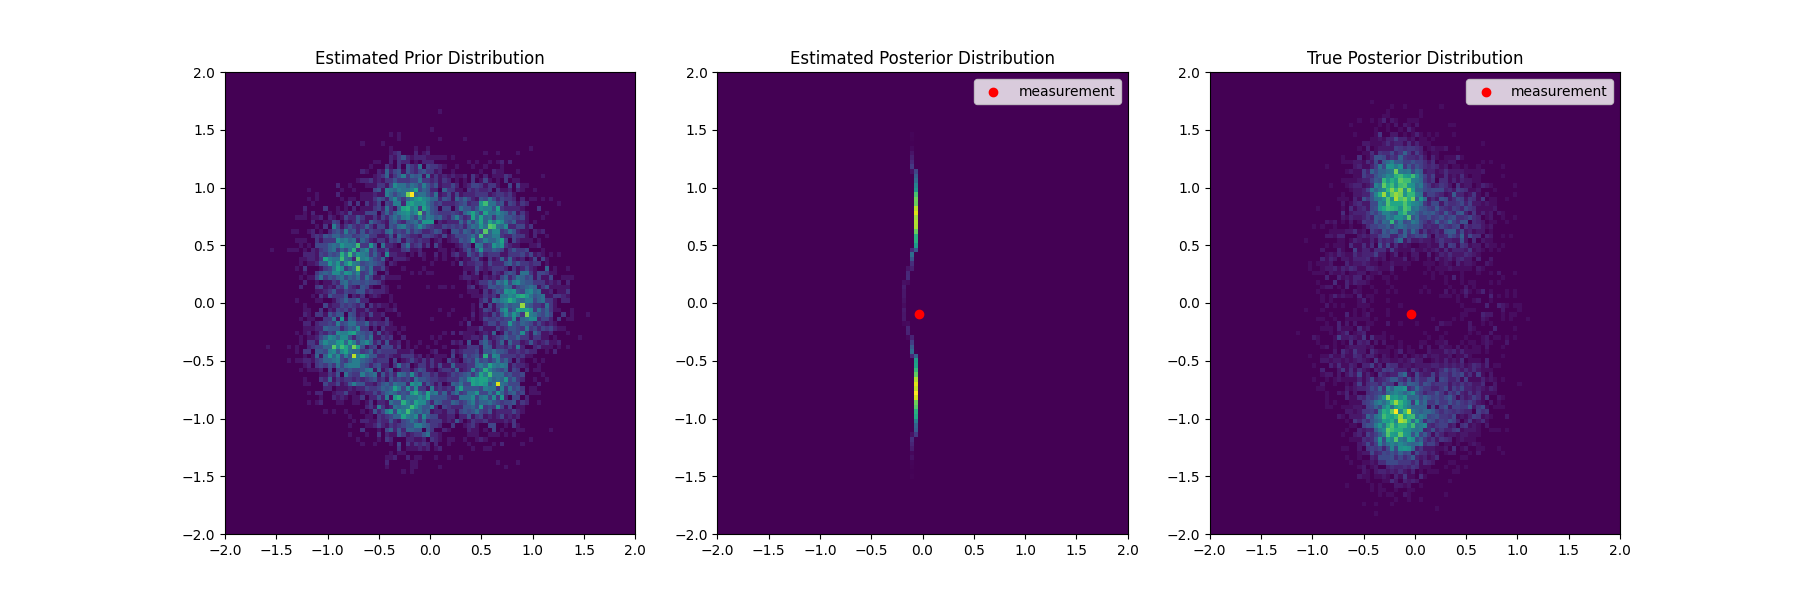

In [26]:
# compare posterior
n_samples = 10000
bins = 100
ddim_config = {'n_ddim_steps': 1000, 'n_steps': 1000, 'beta_min': 1e-4, 'beta_max': 0.02, 'eta': 1}
x_t = torch.randn(n_samples,2).to(device)
traj = guided_ddim_sampler_gt_score(gmm, y,ddim_config , x_t, likelihood_weight=0.005)
traj_xprior = guided_ddim_sampler_gt_score(gmm, y,ddim_config , x_t, likelihood_weight=0.00)

# sample from true posterior
ground_truth_samples = measurement_model.sample_posterior(y.detach().cpu().numpy(), n_samples)
# plot posterior distribution
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

#plot estimated prior
axs[0].set_title('Estimated Prior Distribution')
hist = axs[0].hist2d(traj_xprior[-1][:,0], traj_xprior[-1][:,1], bins=bins, range=[[-2, 2], [-2, 2]])

# Plot estimated posterior distribution
axs[1].set_title('Estimated Posterior Distribution')
hist = axs[1].hist2d(traj[-1][:,0], traj[-1][:,1], bins=bins, range=[[-2, 2], [-2, 2]])
axs[1].scatter(y[0,0].detach().cpu().numpy(), y[0,1].detach().cpu().numpy(), c='r')
axs[1].legend(['measurement'])

# Plot true posterior distribution
axs[2].set_title('True Posterior Distribution')
hist = axs[2].hist2d(ground_truth_samples[:,0], ground_truth_samples[:,1], bins=bins, range=[[-2, 2], [-2, 2]])
axs[2].scatter(y[0,0].detach().cpu().numpy(), y[0,1].detach().cpu().numpy(), c='r')
axs[2].legend(['measurement'])

plt.show()
# compute Wasserstein distance of posterior samples and true posterior
estimated_samples = traj[-1]



In [27]:
def compute_WD(ground_truth_samples, estimated_samples):
    bins = 75
    H1, x_edges, y_edges = np.histogram2d(ground_truth_samples[:, 0], ground_truth_samples[:, 1], bins=bins, range=[[-1.5, 1.5], [-1.5, 1.5]])
    H2, _, _ = np.histogram2d(estimated_samples[:, 0], estimated_samples[:, 1], bins=bins, range=[[-1.5, 1.5], [-1.5, 1.5]])
    # normalize
    H1 = H1 / np.sum(H1)
    H2 = H2 / np.sum(H2)
    # Create cost matrix for the binned data
    x_centers = 0.5 * (x_edges[:-1] + x_edges[1:])  # Bin centers for x
    y_centers = 0.5 * (y_edges[:-1] + y_edges[1:])  # Bin centers for y

    # Create a grid of centers
    X, Y = np.meshgrid(x_centers, y_centers)

    # Flatten the grid to match flattened histograms
    grid_points = np.stack([X.ravel(), Y.ravel()], axis=1)

    # Compute pairwise squared distances between all grid points
    cost_matrix = np.linalg.norm(grid_points[:, None, :] - grid_points[None, :, :], axis=2)


    wasserstein_distance_histogram = emd2(H1.flatten(), H2.flatten(), cost_matrix)
    return wasserstein_distance_histogram

In [28]:
wd_distances = []
for y in y_measurements:
    # compare posterior
    n_samples = 10000
    bins = 75
    ddim_config = {'n_ddim_steps': 100, 'n_steps': 1000, 'beta_min': 1e-4, 'beta_max': 0.02, 'eta': 0.0}
    
    x_t = torch.randn(n_samples,2).to(device)
    traj = guided_ddim_sampler_gt_score(gmm, y,ddim_config , x_t)
    # sample from true posterior
    ground_truth_samples = measurement_model.sample_posterior(y.detach().cpu().numpy(), n_samples)
    # histogram
    wasserstein_distance_histogram = compute_WD(ground_truth_samples, traj[-1])
    print("Wasserstein Distance on Binned Data:", wasserstein_distance_histogram)
    wd_distances.append(wasserstein_distance_histogram)
wd_distances = np.array(wd_distances)
print("Mean Wasserstein Distance:", np.mean(wd_distances))


Wasserstein Distance on Binned Data: 0.2397112733584694
Wasserstein Distance on Binned Data: 0.2515699414919873
Wasserstein Distance on Binned Data: 0.261432046374503
Wasserstein Distance on Binned Data: 0.2649607096795651
Wasserstein Distance on Binned Data: 0.28968286388326653
Wasserstein Distance on Binned Data: 0.33778924989538955
Wasserstein Distance on Binned Data: 0.2406618747367386
Wasserstein Distance on Binned Data: 0.30885246537684
Wasserstein Distance on Binned Data: 0.2979042289426738
Wasserstein Distance on Binned Data: 0.2775780598937926
Wasserstein Distance on Binned Data: 0.2825417180600535
Wasserstein Distance on Binned Data: 0.2986377100676652
Wasserstein Distance on Binned Data: 0.32730151503896027
Wasserstein Distance on Binned Data: 0.23936807687567635
Wasserstein Distance on Binned Data: 0.29715097988742206
Wasserstein Distance on Binned Data: 0.30775668023217845
Wasserstein Distance on Binned Data: 0.27700810860268754
Wasserstein Distance on Binned Data: 0.32880

In [493]:
# compute wassserstein distances between estimated prior and true prior
x_samples = gaussian_circle(100000)
# 1. DDIM
computed_wd = compute_WD(traj_xprior[-1], x_samples)
print(f"Computed Wasserstein Distance DDPM: {computed_wd}")


Computed Wasserstein Distance DDPM: 0.08779620618940512
Computed Wasserstein Distance Flow Matching: 0.047968193121503


In [798]:
# plot score at every time t for the GMM
# all coordinates in the range -2, 2
res = 50
xx, yy = np.meshgrid(np.linspace(-2, 2, res), np.linspace(-2, 2, res))
x = np.stack([xx, yy], axis=-1).reshape(-1, 2)
x = torch.Tensor(x).to(device)
timesteps = np.arange(n_steps,1,-skip).astype(int) - 1
betas = torch.linspace(ddim_config['beta_min'],ddim_config['beta_max'],n_steps).to(device)
alpha = 1 - betas
alpha_cumprod = torch.cumprod(alpha, 0)
scores = []
for t, t_next in zip(timesteps, np.concatenate([timesteps[1:], [0]])):
    with torch.no_grad():
        a_t = alpha_cumprod[t]
        a_t_next = alpha_cumprod[t_next]
        scaled_gmm = gmm.scale(a_t)
        noise_cov = torch.eye(2) * (1-a_t)
        noised_gmm = scaled_gmm.add_noise(noise_cov)
        score = noised_gmm.log_pdf_gradient(x)
        scores.append(score)


In [802]:
# plot score at every time t for the GMM as a vector field
# all coordinates in the range -2, 2
import cv2 
from io import BytesIO


frame_size = (546, 435)  # Adjust based on your saved image dimensions
fps = 30  # Frames per second
out = cv2.VideoWriter('gt_score.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, frame_size)
skip_frames = 3
for i, score in enumerate(scores[::skip_frames]):
    U = score[:,0].reshape(res,res)/3
    V = score[:,1].reshape(res,res)/3
    M = np.hypot(U, V)
    fig, ax = plt.subplots()
    plt.title(f'Score at t={1000-i*skip_frames}')
    plt.quiver(xx, yy, U,V,M)
    # plt.show()
    # plt.savefig(f'./gt_score/gt_score_at_{1000-i}.png',bbox_inches='tight')

    # frame = cv2.imread(f'./gt_score/gt_score_at_{1000-i}.png')
    frame = cv2.resize(frame, frame_size)  # Resize to match video frame size
    buf = BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight')
    plt.close(fig)
    buf.seek(0)
    image_array = np.frombuffer(buf.getvalue(), dtype=np.uint8)
    # Decode the numpy array as an image
    frame = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
    frame = cv2.resize(frame, frame_size)
    out.write(frame)
out.release()

/var/folders/jl/3dg2_4_119d9bmblgpt2b_gc0000gn/T/ipykernel_25920/1842594453.py:14: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  M = np.hypot(U, V)
